In [1]:
# 导入所有需要的library和package

import pandas as pd 
import numpy as np
import math 
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl


from mpl_toolkits.mplot3d import Axes3D

from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

plt.style.use('_mpl-gallery')
mpl.rcParams['font.sans-serif'] = ['SimHei']   #显示中文
mpl.rcParams['axes.unicode_minus']= False       #显示负号

__导入需要分析的数据表__

In [2]:
# 从总表中导入"三方仓明细汇总" 工作表

df_三方仓明细汇总 = pd.read_excel("自有仓及三方仓库存库龄数据-2023年6月 (1).xlsx","三方仓明细汇总")

# 导入仓储费报价
df_仓储费 = pd.read_excel("自有仓及三方仓库存库龄数据-2023年6月 (1).xlsx","仓储费报价")

__整理数据表__

In [3]:
#选取需要的subset
df_仓储费 = df_仓储费.iloc[6:, 0:13]

#重命名column，将第一行内容作为列名
df_仓储费.columns = df_仓储费.iloc[0]

# 不需要第一行
df_仓储费 = df_仓储费.iloc[1:]

# 去掉第一列的空值的行，然后重置index
df_仓储费 = df_仓储费.dropna(subset = ['辅助']).reset_index(drop = True)

# 去掉不需要的列
df_仓储费 = df_仓储费.drop(columns = ['项目','货型'])

In [4]:
df_仓储费.head(5)

6,辅助,0-30天,31-60天,61-90天,91-120天,121-180天,181-270天,271-360天,360天以上,旺季附加费\n10-12月,单位
0,4PX英国仓T25,0,0,0.21,0.32,0.32,0.65,0.65,1.52,0.2,GBP/立方/天
1,4PX英国仓T50,0,0,0.21,0.32,0.32,0.65,0.65,1.52,0.2,GBP/立方/天
2,4PX英国仓T120,0,0,0.21,0.32,0.32,0.65,0.65,1.52,0.2,GBP/立方/天
3,4PX英国仓T240,0,0,0.36,0.69,0.69,1.74,1.74,3.47,0.2,GBP/立方/天
4,4PX英国仓TM,0,0,0.44,0.97,0.97,2.31,2.31,4.62,0.2,GBP/立方/天


In [5]:
# 查看三方仓明细汇总的列
df_三方仓明细汇总.columns

Index(['仓库', '细分仓', 'SKU编码', 'SKU名称', '在库库存', '库龄(天)', '库龄段', '货型', '辅助',
       '仓租报价 原币/天', '仓储费 原币/天', '币种', 'SKU长', 'SKU宽', 'SKU高', 'SKU重量', '总体积',
       '业务线', '销售部门', '总监', '货值'],
      dtype='object')

In [6]:
# 筛选需要用的列组成新的数据表

col = ['仓库','货型','SKU编码','库龄(天)', '库龄段', '币种','总体积', '货值']
df_三方仓明细汇总 = df_三方仓明细汇总[col].dropna().reset_index(drop = True )
df_三方仓明细汇总

,仓库,货型,SKU编码,库龄(天),库龄段,币种,总体积,货值
0,易达云美国仓,T240,AMA005571_B_US,2,0-30天,USD,26.993064,141982.3440
1,易达云美国仓,T240,AMA005571_B_US_PP,15,0-30天,USD,40.526640,207770.0660
2,易达云美国仓,T240,AMA005571_BL_US,2,0-30天,USD,6.732000,42256.6500
3,易达云美国仓,T240,AMA005571_S_US,2,0-30天,USD,32.616619,171561.9990
4,易达云美国仓,T240,AMA005571_S_US_PP,15,0-30天,USD,20.330640,104230.1660
...,...,...,...,...,...,...,...,...
1516,4PX英国仓,T50,SYB000635_GY_1,732,360天以上,GBP,0.582400,3847.0720
1517,4PX英国仓,T50,SYB000635_GY_2,736,360天以上,GBP,0.197505,1667.2392
1518,4PX英国仓,T50,SYG000028,668,360天以上,GBP,0.139392,2973.4400
1519,4PX英国仓,T50,TGG000001_W,190,181-270天,GBP,0.253500,1648.6800


In [7]:
# 合并“细分仓”和“货型”

df = df_三方仓明细汇总

# 使用 apply() 函数将两个列合并为一列
df['辅助'] = df.apply(lambda row: row['仓库'] + row['货型'], axis=1)

# 已经有了辅助列了，所以drop原本的'细分仓'和'货型'
df = df.drop(columns = ['仓库','货型'])

# 将新家的'辅助列'移到df的第一列
last_col = df.pop('辅助')
df.insert(0, '辅助', last_col)

df_new_三方仓明细 = df
df_new_三方仓明细

,辅助,SKU编码,库龄(天),库龄段,币种,总体积,货值
0,易达云美国仓T240,AMA005571_B_US,2,0-30天,USD,26.993064,141982.3440
1,易达云美国仓T240,AMA005571_B_US_PP,15,0-30天,USD,40.526640,207770.0660
2,易达云美国仓T240,AMA005571_BL_US,2,0-30天,USD,6.732000,42256.6500
3,易达云美国仓T240,AMA005571_S_US,2,0-30天,USD,32.616619,171561.9990
4,易达云美国仓T240,AMA005571_S_US_PP,15,0-30天,USD,20.330640,104230.1660
...,...,...,...,...,...,...,...
1516,4PX英国仓T50,SYB000635_GY_1,732,360天以上,GBP,0.582400,3847.0720
1517,4PX英国仓T50,SYB000635_GY_2,736,360天以上,GBP,0.197505,1667.2392
1518,4PX英国仓T50,SYG000028,668,360天以上,GBP,0.139392,2973.4400
1519,4PX英国仓T50,TGG000001_W,190,181-270天,GBP,0.253500,1648.6800


In [8]:
df_仓储费.head(5) 

6,辅助,0-30天,31-60天,61-90天,91-120天,121-180天,181-270天,271-360天,360天以上,旺季附加费\n10-12月,单位
0,4PX英国仓T25,0,0,0.21,0.32,0.32,0.65,0.65,1.52,0.2,GBP/立方/天
1,4PX英国仓T50,0,0,0.21,0.32,0.32,0.65,0.65,1.52,0.2,GBP/立方/天
2,4PX英国仓T120,0,0,0.21,0.32,0.32,0.65,0.65,1.52,0.2,GBP/立方/天
3,4PX英国仓T240,0,0,0.36,0.69,0.69,1.74,1.74,3.47,0.2,GBP/立方/天
4,4PX英国仓TM,0,0,0.44,0.97,0.97,2.31,2.31,4.62,0.2,GBP/立方/天


In [9]:
# 合并两个表，关键列为“辅助”
merged_df = pd.merge(df_new_三方仓明细, df_仓储费, on='辅助', how = 'left')

In [10]:
merged_df.head(5)

,辅助,SKU编码,库龄(天),库龄段,币种,总体积,货值,0-30天,31-60天,61-90天,91-120天,121-180天,181-270天,271-360天,360天以上,旺季附加费\n10-12月,单位
0,易达云美国仓T240,AMA005571_B_US,2,0-30天,USD,26.993064,141982.344,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天
1,易达云美国仓T240,AMA005571_B_US_PP,15,0-30天,USD,40.526640,207770.066,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天
2,易达云美国仓T240,AMA005571_BL_US,2,0-30天,USD,6.732000,42256.650,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天
3,易达云美国仓T240,AMA005571_S_US,2,0-30天,USD,32.616619,171561.999,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天
4,易达云美国仓T240,AMA005571_S_US_PP,15,0-30天,USD,20.330640,104230.166,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天


### __分析思路__

<font color = brown>*__情况__*</font>

库龄数据记录了公司各个仓库库存的储存天数，仓储费，库龄段，等等信息。

<font color = brown>*__目的__*</font>

哪些库存需要报废处理，用什么指标来判断，是否可以提前预测需要报废的库存？通过对库龄的分析，及时处理滞留的库存，减少公司物流在仓储费这一部分的成本。

<font color = brown>*__解决问题思路__*</font>

如果库存的货值大于入库到目前所产生的仓储费，那么不需要进行报废处理。反之，如果累计的仓储费大于货值，继续储存在仓库会产生更多的费用，物流的成本也随之提高。

首先我们将“三方仓明细汇总”和“仓储费报价”两个表导入。 我们需要计算每一个SKU编码的累计仓储费，所以将两个表联合，方便计算。

为了快速并且反复进行同样的处理数据的步骤，我设计了一个公式。公式可以计算累计仓储费并且转换其为人民币为单位的数值，然后获取货值大于累计仓储费的SKU编号，得到可以报废和不需要报废的库存信息，并且通过画图来更直观的表现。

__（1）定义一个将所有货币按照汇率转换成人民币的公式__

In [11]:
# 定制transfer_currency公式，将所有非人民币的仓储费转换为人民币

def transfer_currency(df, col_1, col_2, col_3):
    
    # col_1: 记录货币种类的列
    # col_2: 

    for i in range(df.shape[0]):

        if df.loc[i, col_1] == 'USD':
                df.loc[i, col_2] = df.loc[i, col_3] *  6.9240 

        elif df.loc[i, col_1] == 'GBP':
                df.loc[i, col_2] = df.loc[i, col_3] * 8.6504 

        elif df.loc[i, col_1] == 'EUR':
                df.loc[i, col_2] = df.loc[i, col_3] * 7.6361

        elif df.loc[i, col_1] == 'CAD':
                df.loc[i, col_2] = df.loc[i, col_3] * 5.0893

        elif df.loc[i, col_1] == 'JPY':
                df.loc[i, col_2] = df.loc[i, col_3] * 0.0517

        else:
                df.loc[i, col_2] = df.loc[i, col_3]   

    return df

__（2）设计一个公式，对数据进行分析__

In [12]:
def get_result():
    
    ### Step1: 定义sum_storage_fee公式，根据库龄，来计算累计仓储费
    
    def sum_storage_fee(df, col_1, col_2, col_3):  

        # df ： 需要用的数据表
        # col_1 ： '库龄(天)'
        # col_2 ： '累计仓储费' (新的列)
        # col_3: "总体积"

        for i in range(df.shape[0]):

            if (0 < df.loc[i, col_1]) & (df.loc[i, col_1] <= 30):
                df.loc[i, col_2] = (df.loc[i, col_1] *  df.loc[i, '0-30天'] * df.loc[i, col_3]) # 库龄乘以0-30库龄段的仓储费

            elif (30 < df.loc[i, col_1]) & (df.loc[i, col_1] <= 60):
                df.loc[i, col_2] =  (df.loc[i, '0-30天'] * 30 * df.loc[i, col_3]) \
                                            + ((df.loc[i, col_1] - 30) * (df.loc[i, '31-60天'] * df.loc[i, col_3])) # 超出30天部分的仓储费

            elif (60 < df.loc[i, col_1]) & (df.loc[i, col_1] <= 90):
                df.loc[i, col_2] =  (df.loc[i, '0-30天'] * 30 * df.loc[i, col_3])\
                                            + (df.loc[i, '31-60天'] * 30 * df.loc[i, col_3])\
                                            + ((df.loc[i, col_1] - 60) * df.loc[i, '61-90天'] * df.loc[i, col_3])

            elif (90 < df.loc[i, col_1]) & (df.loc[i, col_1] <= 120):
                df.loc[i, col_2] =  (df.loc[i, '0-30天'] * 30 * df.loc[i, col_3])\
                                            + (df.loc[i, '31-60天'] * 30 * df.loc[i, col_3])\
                                            + (df.loc[i, '61-90天'] * 30 * df.loc[i, col_3])\
                                            + ((df.loc[i, col_1] - 90) * df.loc[i, '91-120天'] * df.loc[i, col_3])

            elif (121 < df.loc[i, col_1]) & (df.loc[i, col_1] <= 180):
                df.loc[i, col_2] =  ((df.loc[i, '0-30天'] * 30)\
                                            + (df.loc[i, '31-60天'] * 30)\
                                            + (df.loc[i, '61-90天'] * 30)\
                                            + (df.loc[i, '91-120天'] * 30)\
                                            + (df.loc[i, col_1] - 120) * df.loc[i, '121-180天']) * df.loc[i, col_3]

            elif (181 < df.loc[i, col_1]) & (df.loc[i, col_1] <= 270):
                df.loc[i, col_2] =  ((df.loc[i, '0-30天'] * 30)\
                                            + (df.loc[i, '31-60天'] * 30)\
                                            + (df.loc[i, '61-90天'] * 30)\
                                            + (df.loc[i, '91-120天'] * 30)\
                                            + (df.loc[i, '121-180天'] * 60)\
                                            + (df.loc[i, col_1] - 180) * df.loc[i, '181-270天']) * df.loc[i, col_3]

            elif (271 < df.loc[i, col_1]) & (df.loc[i, col_1] <= 360):
                df.loc[i, col_2] =  ((df.loc[i, '0-30天'] * 30)\
                                            + (df.loc[i, '31-60天'] * 30)\
                                            + (df.loc[i, '61-90天'] * 30)\
                                            + (df.loc[i, '91-120天'] * 30)\
                                            + (df.loc[i, '121-180天'] * 60)\
                                            + (df.loc[i, '181-270天'] * 90)\
                                            + (df.loc[i, col_1] - 270) * df.loc[i, '271-360天']) * df.loc[i, col_3]

            else:
                df.loc[i, col_2] =  ((df.loc[i, '0-30天'] * 30)\
                                            + (df.loc[i, '31-60天'] * 30)\
                                            + (df.loc[i, '61-90天'] * 30)\
                                            + (df.loc[i, '91-120天'] * 30)\
                                            + (df.loc[i, '121-180天'] * 60)\
                                            + (df.loc[i, '181-270天'] * 90)\
                                            + (df.loc[i, '271-360天'] * 90)\
                                            + ((df.loc[i, col_1] - 360) * df.loc[i, '360天以上'])) * df.loc[i, col_3]

        return df 
    
    ### Step 2: 使用fucntion得到'累计仓储费'
    
    sum_storage_fee(merged_df, '库龄(天)', '累计仓储费', '总体积')
    
    ### Step 3: 取需要用的列
    
    df = merged_df[['辅助', 'SKU编码', '库龄(天)', '库龄段', '币种', '货值','累计仓储费']]
    display(df)
    
    
    ### Step 4: 将累计仓储费的单位转换为人民币

    df = df.copy()  # 复制一份原始 DataFrame
    transfer_currency(df, '币种', '累计仓储（RMB）', '累计仓储费')
    display(df)
    
    ### Step 5：找出不需要报废, 货值大于累计仓储费的数据

    df_1 = df[df['货值'] > df['累计仓储（RMB）']][['SKU编码']]
    display(df_1)
     

    ### Step 6：画图
    
    df = df
    
    # 计算列的均值和标准差, 去掉outliers
    mean = df['货值'].mean()
    std = df['货值'].std()

    # 设定一个阈值，例如均值加/减三倍标准差
    threshold = mean + 3 * std

    # 筛选出不超过阈值以及累计仓储（RMB）为正数的行
    filtered_df = df[(df['货值'] <= threshold) & (df['累计仓储（RMB）'] >= 0)]
    
    # 使用 seaborn 绘制散点图
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.scatterplot(
                        x='货值', 
                        y='累计仓储（RMB）', 
                        hue='货值',  
                        data=filtered_df, 
                        palette="Set3", 
                        legend=False,
                        ax = ax)


    # 获取符合条件的数据点
    mask = filtered_df['货值'] == filtered_df['累计仓储（RMB）']
    x = filtered_df[mask]['货值'].values
    y = filtered_df[mask]['累计仓储（RMB）'].values

    ax.axline((0, 0), slope=1,color = 'r')

    # 设置图表标题和轴标签
    ax.set_title('货值与仓储费关系')
    ax.set_xlabel('货值')
    ax.set_ylabel('累计仓储（RMB）')

    plt.show()



### __当前库龄的数据__

,辅助,SKU编码,库龄(天),库龄段,币种,货值,累计仓储费
0,易达云美国仓T240,AMA005571_B_US,2,0-30天,USD,141982.3440,0.000000
1,易达云美国仓T240,AMA005571_B_US_PP,15,0-30天,USD,207770.0660,0.000000
2,易达云美国仓T240,AMA005571_BL_US,2,0-30天,USD,42256.6500,0.000000
3,易达云美国仓T240,AMA005571_S_US,2,0-30天,USD,171561.9990,0.000000
4,易达云美国仓T240,AMA005571_S_US_PP,15,0-30天,USD,104230.1660,0.000000
...,...,...,...,...,...,...,...
1516,4PX英国仓T50,SYB000635_GY_1,732,360天以上,GBP,3847.0720,417.895296
1517,4PX英国仓T50,SYB000635_GY_2,736,360天以上,GBP,1667.2392,142.918568
1518,4PX英国仓T50,SYG000028,668,360天以上,GBP,2973.4400,86.459282
1519,4PX英国仓T50,TGG000001_W,190,181-270天,GBP,1648.6800,10.545600


,辅助,SKU编码,库龄(天),库龄段,币种,货值,累计仓储费,累计仓储（RMB）
0,易达云美国仓T240,AMA005571_B_US,2,0-30天,USD,141982.3440,0.000000,0.000000
1,易达云美国仓T240,AMA005571_B_US_PP,15,0-30天,USD,207770.0660,0.000000,0.000000
2,易达云美国仓T240,AMA005571_BL_US,2,0-30天,USD,42256.6500,0.000000,0.000000
3,易达云美国仓T240,AMA005571_S_US,2,0-30天,USD,171561.9990,0.000000,0.000000
4,易达云美国仓T240,AMA005571_S_US_PP,15,0-30天,USD,104230.1660,0.000000,0.000000
...,...,...,...,...,...,...,...,...
1516,4PX英国仓T50,SYB000635_GY_1,732,360天以上,GBP,3847.0720,417.895296,3614.961469
1517,4PX英国仓T50,SYB000635_GY_2,736,360天以上,GBP,1667.2392,142.918568,1236.302781
1518,4PX英国仓T50,SYG000028,668,360天以上,GBP,2973.4400,86.459282,747.907372
1519,4PX英国仓T50,TGG000001_W,190,181-270天,GBP,1648.6800,10.545600,91.223658


,SKU编码
0,AMA005571_B_US
1,AMA005571_B_US_PP
2,AMA005571_BL_US
3,AMA005571_S_US
4,AMA005571_S_US_PP
...,...
1516,SYB000635_GY_1
1517,SYB000635_GY_2
1518,SYG000028
1519,TGG000001_W


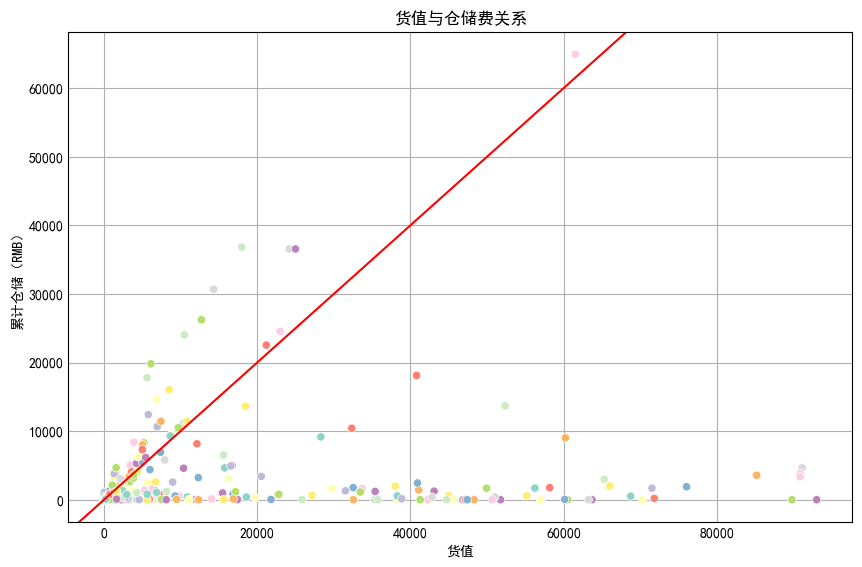

In [13]:
get_result()

### __对当前库龄数据的分析：__





图标选择了散点图，每一个点代表每一条数据。图中的红线代表货值与累计仓储费齐平，在红线上面的点代表货值小于累计仓储的库存，应当进行报废处理。红线下面的点代表货值大于累计仓储的库存，当下不需要报废处理。

当前数据表记录的库龄的累计仓储费来和货值进行对比，货值大于累计仓储费的SKU有1106个，这一批货物目前不需要进行报废处理。而剩下的是货值小于累计仓储费的库存，建议进行报废处理，继续存储在仓库会产生更多费用。


### __未来一个月的仓储数据__

In [14]:
merged_df = merged_df.copy()  # 复制一份原始 DataFrame
merged_df['库龄(天)'] = merged_df['库龄(天)'] + 30  # 将 ['库龄/天(下个月)'] 列加上 30 并赋值给新 DataFrame
merged_df.head(5)

,辅助,SKU编码,库龄(天),库龄段,币种,总体积,货值,0-30天,31-60天,61-90天,91-120天,121-180天,181-270天,271-360天,360天以上,旺季附加费\n10-12月,单位,累计仓储费
0,易达云美国仓T240,AMA005571_B_US,32,0-30天,USD,26.993064,141982.344,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天,0.0
1,易达云美国仓T240,AMA005571_B_US_PP,45,0-30天,USD,40.526640,207770.066,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天,0.0
2,易达云美国仓T240,AMA005571_BL_US,32,0-30天,USD,6.732000,42256.650,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天,0.0
3,易达云美国仓T240,AMA005571_S_US,32,0-30天,USD,32.616619,171561.999,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天,0.0
4,易达云美国仓T240,AMA005571_S_US_PP,45,0-30天,USD,20.330640,104230.166,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天,0.0


,辅助,SKU编码,库龄(天),库龄段,币种,货值,累计仓储费
0,易达云美国仓T240,AMA005571_B_US,32,0-30天,USD,141982.3440,0.000000
1,易达云美国仓T240,AMA005571_B_US_PP,45,0-30天,USD,207770.0660,0.000000
2,易达云美国仓T240,AMA005571_BL_US,32,0-30天,USD,42256.6500,0.000000
3,易达云美国仓T240,AMA005571_S_US,32,0-30天,USD,171561.9990,0.000000
4,易达云美国仓T240,AMA005571_S_US_PP,45,0-30天,USD,104230.1660,0.000000
...,...,...,...,...,...,...,...
1516,4PX英国仓T50,SYB000635_GY_1,762,360天以上,GBP,3847.0720,444.452736
1517,4PX英国仓T50,SYB000635_GY_2,766,360天以上,GBP,1667.2392,151.924796
1518,4PX英国仓T50,SYG000028,698,360天以上,GBP,2973.4400,92.815557
1519,4PX英国仓T50,TGG000001_W,220,181-270天,GBP,1648.6800,15.488850


,辅助,SKU编码,库龄(天),库龄段,币种,货值,累计仓储费,累计仓储（RMB）
0,易达云美国仓T240,AMA005571_B_US,32,0-30天,USD,141982.3440,0.000000,0.000000
1,易达云美国仓T240,AMA005571_B_US_PP,45,0-30天,USD,207770.0660,0.000000,0.000000
2,易达云美国仓T240,AMA005571_BL_US,32,0-30天,USD,42256.6500,0.000000,0.000000
3,易达云美国仓T240,AMA005571_S_US,32,0-30天,USD,171561.9990,0.000000,0.000000
4,易达云美国仓T240,AMA005571_S_US_PP,45,0-30天,USD,104230.1660,0.000000,0.000000
...,...,...,...,...,...,...,...,...
1516,4PX英国仓T50,SYB000635_GY_1,762,360天以上,GBP,3847.0720,444.452736,3844.693947
1517,4PX英国仓T50,SYB000635_GY_2,766,360天以上,GBP,1667.2392,151.924796,1314.210256
1518,4PX英国仓T50,SYG000028,698,360天以上,GBP,2973.4400,92.815557,802.891695
1519,4PX英国仓T50,TGG000001_W,220,181-270天,GBP,1648.6800,15.488850,133.984748


,SKU编码
0,AMA005571_B_US
1,AMA005571_B_US_PP
2,AMA005571_BL_US
3,AMA005571_S_US
4,AMA005571_S_US_PP
...,...
1516,SYB000635_GY_1
1517,SYB000635_GY_2
1518,SYG000028
1519,TGG000001_W


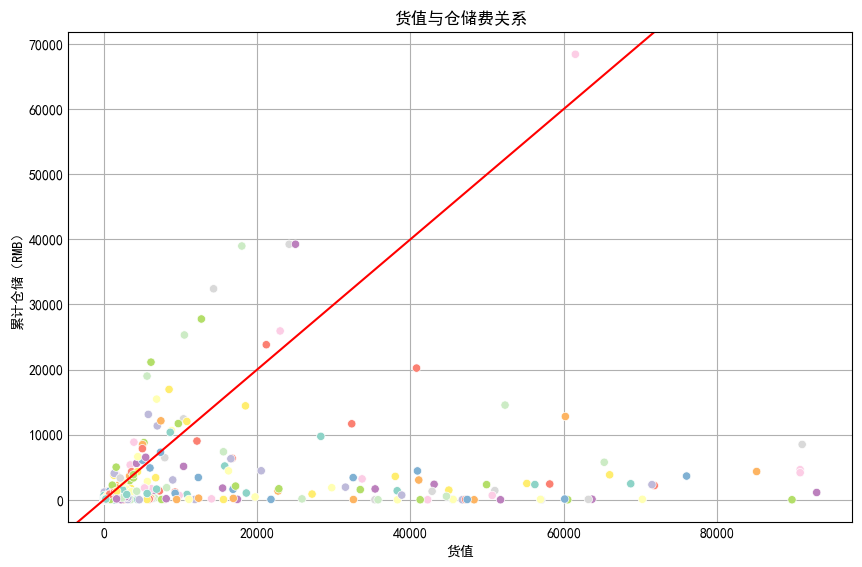

In [15]:
get_result()

### __未来一个月数据的分析：__

基于当前的库龄数据，未来一个月，假设所有的库存都依然放在仓库，则所有的库存货物的库龄都增加30天.

计算过了一个月的累计仓储费之后，和货值进行对比，和预期的一样，货值大于累计仓储费的SKU数量减少到了1089个。

可见，有一部分的货物的累计仓储费在继续储存了一个月之后超过了其货值。这一批货物就是需要预警的货物，虽然不需要马上报废，但是应该在一个月内处理掉。 

### __未来3个月的仓储数据__

In [16]:
merged_df = merged_df.copy()  # 复制一份原始 DataFrame
merged_df['库龄(天)'] = merged_df['库龄(天)'] + 90  # 将 ['库龄/天(下个月)'] 列加上 30 并赋值给新 DataFrame
merged_df.head(5)

,辅助,SKU编码,库龄(天),库龄段,币种,总体积,货值,0-30天,31-60天,61-90天,91-120天,121-180天,181-270天,271-360天,360天以上,旺季附加费\n10-12月,单位,累计仓储费
0,易达云美国仓T240,AMA005571_B_US,122,0-30天,USD,26.993064,141982.344,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天,0.0
1,易达云美国仓T240,AMA005571_B_US_PP,135,0-30天,USD,40.526640,207770.066,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天,0.0
2,易达云美国仓T240,AMA005571_BL_US,122,0-30天,USD,6.732000,42256.650,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天,0.0
3,易达云美国仓T240,AMA005571_S_US,122,0-30天,USD,32.616619,171561.999,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天,0.0
4,易达云美国仓T240,AMA005571_S_US_PP,135,0-30天,USD,20.330640,104230.166,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天,0.0


,辅助,SKU编码,库龄(天),库龄段,币种,货值,累计仓储费
0,易达云美国仓T240,AMA005571_B_US,122,0-30天,USD,141982.3440,641.271522
1,易达云美国仓T240,AMA005571_B_US_PP,135,0-30天,USD,207770.0660,1362.637348
2,易达云美国仓T240,AMA005571_BL_US,122,0-30天,USD,42256.6500,159.931451
3,易达云美国仓T240,AMA005571_S_US,122,0-30天,USD,171561.9990,774.869756
4,易达云美国仓T240,AMA005571_S_US_PP,135,0-30天,USD,104230.1660,683.582191
...,...,...,...,...,...,...,...
1516,4PX英国仓T50,SYB000635_GY_1,852,360天以上,GBP,3847.0720,524.125056
1517,4PX英国仓T50,SYB000635_GY_2,856,360天以上,GBP,1667.2392,178.943480
1518,4PX英国仓T50,SYG000028,788,360天以上,GBP,2973.4400,111.884383
1519,4PX英国仓T50,TGG000001_W,310,181-270天,GBP,1648.6800,30.318600


,辅助,SKU编码,库龄(天),库龄段,币种,货值,累计仓储费,累计仓储（RMB）
0,易达云美国仓T240,AMA005571_B_US,122,0-30天,USD,141982.3440,641.271522,4440.164019
1,易达云美国仓T240,AMA005571_B_US_PP,135,0-30天,USD,207770.0660,1362.637348,9434.901000
2,易达云美国仓T240,AMA005571_BL_US,122,0-30天,USD,42256.6500,159.931451,1107.365365
3,易达云美国仓T240,AMA005571_S_US,122,0-30天,USD,171561.9990,774.869756,5365.198190
4,易达云美国仓T240,AMA005571_S_US_PP,135,0-30天,USD,104230.1660,683.582191,4733.123093
...,...,...,...,...,...,...,...,...
1516,4PX英国仓T50,SYB000635_GY_1,852,360天以上,GBP,3847.0720,524.125056,4533.891384
1517,4PX英国仓T50,SYB000635_GY_2,856,360天以上,GBP,1667.2392,178.943480,1547.932680
1518,4PX英国仓T50,SYG000028,788,360天以上,GBP,2973.4400,111.884383,967.844664
1519,4PX英国仓T50,TGG000001_W,310,181-270天,GBP,1648.6800,30.318600,262.268017


,SKU编码
0,AMA005571_B_US
1,AMA005571_B_US_PP
2,AMA005571_BL_US
3,AMA005571_S_US
4,AMA005571_S_US_PP
...,...
1515,SYB000635_BL_2
1517,SYB000635_GY_2
1518,SYG000028
1519,TGG000001_W


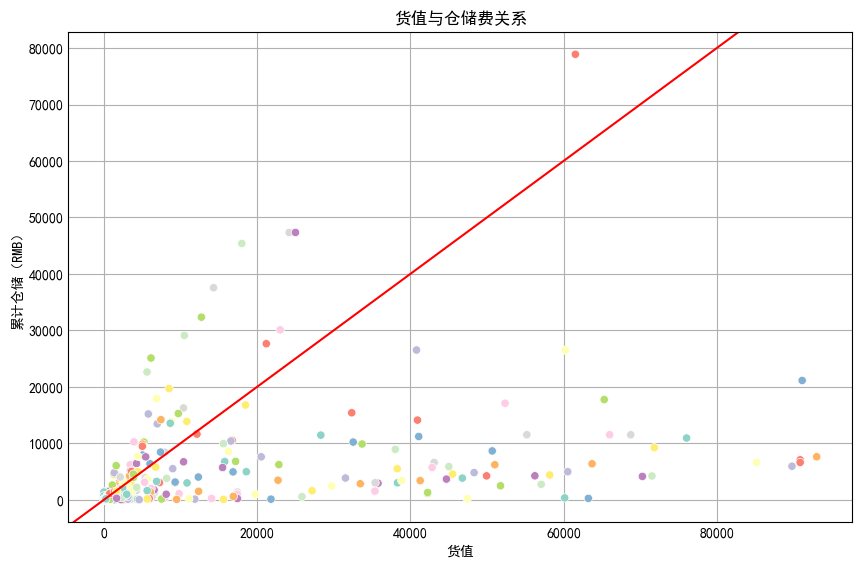

In [17]:
get_result()

### __对未来三个月的库龄数据的分析__

和上面的思路一样，过了两个月，累计仓储费大于货值的数量增加了，不需要的报废处理的SKU货物数量降低到了1018。 

### __已有库龄数据分析思路__

使用get_result()公式可以得到当前库龄数据的分析，以及未来和过去的的库龄的库龄。

使用这个公式可以看有多少库存在一个月（二个月/ 三个月/ 半年，等等）后需要报废，也可以看当前库龄的一个月（二个月/ 三个月/ 半年，等等）之前有多少库存是应当早点报废的。 


### __预测报废库龄__



在已有库龄数据上找出那些累计仓储费大于货值（需要报废处理）的库存虽然可以及时止损，但是总是会有一部分货物已经产生了比货值多很多的仓储费，已经给公司造成了损失。

为了更大程度的避免高额仓储费， 我想要设计一个公式，在货物入库的时候就预测出它的的库龄在达到多少天之前就需要处理掉。相当于找到一个报废的警戒线，这个值代表了，超过这个库龄天数的时候，累计仓储大于货值，代表着损失。这样在仓库入库的最开始就可以根据每一批货物的报废预警值来分类处理。

假设在入库的时候，我可以得到的信息有：仓库，货型，SKU编码，币种，货值，每个库龄段的仓储费，我根据这些信息假设一个x值，当库龄达到x天的时候，累计仓储约等于货值。 

In [18]:
merged_df

,辅助,SKU编码,库龄(天),库龄段,币种,总体积,货值,0-30天,31-60天,61-90天,91-120天,121-180天,181-270天,271-360天,360天以上,旺季附加费\n10-12月,单位,累计仓储费
0,易达云美国仓T240,AMA005571_B_US,122,0-30天,USD,26.993064,141982.3440,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天,641.271522
1,易达云美国仓T240,AMA005571_B_US_PP,135,0-30天,USD,40.526640,207770.0660,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天,1362.637348
2,易达云美国仓T240,AMA005571_BL_US,122,0-30天,USD,6.732000,42256.6500,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天,159.931451
3,易达云美国仓T240,AMA005571_S_US,122,0-30天,USD,32.616619,171561.9990,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天,774.869756
4,易达云美国仓T240,AMA005571_S_US_PP,135,0-30天,USD,20.330640,104230.1660,0,0,0.3177,0.4236,0.75895,1.50025,1.74735,3.2476,0.05295,USD/立方/天,683.582191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,4PX英国仓T50,SYB000635_GY_1,852,360天以上,GBP,0.582400,3847.0720,0,0,0.21,0.32,0.32,0.65,0.65,1.52,0.2,GBP/立方/天,524.125056
1517,4PX英国仓T50,SYB000635_GY_2,856,360天以上,GBP,0.197505,1667.2392,0,0,0.21,0.32,0.32,0.65,0.65,1.52,0.2,GBP/立方/天,178.943480
1518,4PX英国仓T50,SYG000028,788,360天以上,GBP,0.139392,2973.4400,0,0,0.21,0.32,0.32,0.65,0.65,1.52,0.2,GBP/立方/天,111.884383
1519,4PX英国仓T50,TGG000001_W,310,181-270天,GBP,0.253500,1648.6800,0,0,0.21,0.32,0.32,0.65,0.65,1.52,0.2,GBP/立方/天,30.318600


In [19]:
# 将不同库龄段写成列，方便之后写for loop
col = ['0-30天', '31-60天', '61-90天', '91-120天', '121-180天', '181-270天', '271-360天', '360天以上']
days = [30, 30, 30, 30, 60, 90, 90]

# 将所有仓储费转换成人民币为单位

for i in range(len(col)):
    transfer_currency(merged_df, '币种',col[i], col[i] )

In [20]:
# 设计function，计算累计仓储费

def calc_累计仓储费(x):
    
    total_days = 0
    total_cost = 0
    
    if x == 0:
        total_cost = 0
        
    if x <=360:
        
        for i in range(len(col)):
            total_days += days[i]
            if x >= total_days:
                total_cost += df[col[i]] * days[i] * df['总体积']
            else:
                break

        total_cost += (x - (total_days - days[i])) * df[col[i]] * df['总体积']
        
    if x > 360:
        
        for i in range(len(days)):
            total_days += days[i]
            total_cost += df[col[i]] * days[i] * df['总体积']
            
                
        total_cost += (x - 360) * df[col[i]] * df['总体积']

        
    return total_cost

In [21]:
df = merged_df

In [22]:

final_df = pd.DataFrame(columns=['SKU编码', '预测报废库龄','报废累计仓储费','货值'])

for i in range(merged_df.shape[0]): 
    
    df = merged_df.iloc[i]
   
    # 设置一个最小值和一个最大值
    L = 0 # 最小库龄为0
    U = 365 * 10 # 假设最大库龄为10年


    # 设定阈值和最大迭代次数
    tolerance = 1
    max_iter = 1000

    # 初始化变量和参数
    fx = calc_累计仓储费(L)
    delta = fx - df['货值'] # 中间得到差值
    iter_count = 0

    #print(f'区间最小值的仓储费{fx}')
    #print(f'区间最小值的仓储费与货值的差价{delta}')

    while np.abs(delta).max() > tolerance and iter_count < max_iter:
        # 计算当前最小值和最大值的平均值
        m = (L + U) / 2

        # 计算当前猜测的库龄对应的累计仓储费
        fx = calc_累计仓储费(m)

        # 更新最小值或最大值
        delta = fx - df['货值']
        
        if np.less(delta, 0).any():
            L = m
        else:
            U = m
            
        # 统计迭代次数
        iter_count += 1

        # 将m值向下取整数
        m = int(m)

    # 0 值代表error值
    if iter_count == max_iter:
        m = 0

    else:
        
        final_df.at[i, '预测报废库龄'] = m
        final_df.at[i, 'SKU编码'] = merged_df['SKU编码'].iloc[i]
        final_df.at[i, '货值'] = merged_df['货值'].iloc[i]
        final_df.at[i, '报废累计仓储费'] = calc_累计仓储费(m)

final_df

,SKU编码,预测报废库龄,报废累计仓储费,货值
0,AMA005571_B_US,588,141755.370162,141982.344
1,AMA005571_B_US_PP,577,207434.098998,207770.066
2,AMA005571_BL_US,672,42195.063044,42256.65
3,AMA005571_S_US,588,171287.738945,171561.999
4,AMA005571_S_US_PP,577,104061.624414,104230.166
...,...,...,...,...
1515,SYB000635_BL_2,1584,1641.36963,1641.978
1516,SYB000635_GY_1,1301,3847.767123,3847.072
1517,SYB000635_GY_2,1627,1666.895344,1667.2392
1519,TGG000001_W,1283,1649.152697,1648.68


### __结果__

我得到了一个新表，记录了‘SKU编码’，‘预测报废库龄’， ‘报废累计仓储费’，‘货值’

<font color = green>*预测报废库龄*<font/>： 
    
    报废预警值，表示这批货物库龄达到这个值的时候如果不报废处理，就会进入亏损
    
    这一列的最小值是0，代表了预测出错，可能原数据表里面存在错误信息，比如说货值为0的情况，预测报废库龄就会是0.

<font color = green>*报废累计仓储费*<font/>： 
    
    到达报废预警值得时候货物所产生的累计仓储费用

<font color = green>*货值*<font/>： 
    
    货物得到货值，放在表里为了可以直观的和报废累计仓储费做比较


新表的行数是1204，不同于原本联表的1521。这是因为，在处理过程中，我将预测报废库龄的上限值设为了10年，也就是（365 x 10） 天。

而预测报废库龄大于这个上限的货物信息，则不会在新表里面。但是其实，这一部分的货物不需要预警，因为库龄超过10年了，其累计仓储费都超越不了货值，说明将它们储存在仓库里超过10年都不到达需要报废的地步。